# Minimum distance between V1 and V3
This notebook estimates the partial volume of V1 and V3 voxels to exclude the possibility that decoding performance in V3 could be influenced by activition in V1.

In [1]:
from pathlib import Path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import matplotlib.pyplot as plt
from src.config import DIR_BASE, SUBJECTS
from nibabel.freesurfer.io import read_geometry, read_label
plt.style.use(os.path.join(module_path, "src", "default.mplstyle"))

# set
LAYER = 10 # 0: white, 10: pial

In [2]:
class Data:
    """Get all vertex coordinates within ROI (V1, V2, V3)."""

    def __init__(self, subj, hemi, area):
        self.subj = subj
        self.hemi = hemi
        self.area = area

    def _load_label(self):
        _file_label = Path(DIR_BASE) / self.subj / f"anatomy/label/{self.hemi}.{self.area}.label"
        label, _ = read_label(_file_label, read_scalars=True)
        return label

    def _load_layer(self, layer):
        _file_layer = Path(DIR_BASE) / self.subj / f"anatomy/layer/{self.hemi}.layer_{layer}"
        vtx, _ = read_geometry(_file_layer)
        return vtx

    @property
    def vtx(self):
        vtx = self._load_layer(LAYER)[self._load_label()]
        return np.array(vtx)

def min_distance(arr_pts, pts):
    """Compute minimum distance between vertex array and reference point."""
    tmp = np.sqrt(np.sum((arr_pts - pts)**2, axis=1))
    return np.min(tmp)

In [3]:
res = []
for subj in SUBJECTS:
    for hemi in ["lh", "rh"]:
        v1 = Data(subj, hemi, "v1").vtx
        v3 = Data(subj, hemi, "v3").vtx
        for v in v3:
            res.append(min_distance(v1, v))

print(f"Mean: {np.mean(res)} mm")
print(f"Min: {np.min(res)} mm")
print(f"Std: {np.std(res)} mm")

Mean: 9.472517184306046 mm
Min: 1.2653887959075132 mm
Std: 3.067881141355138 mm


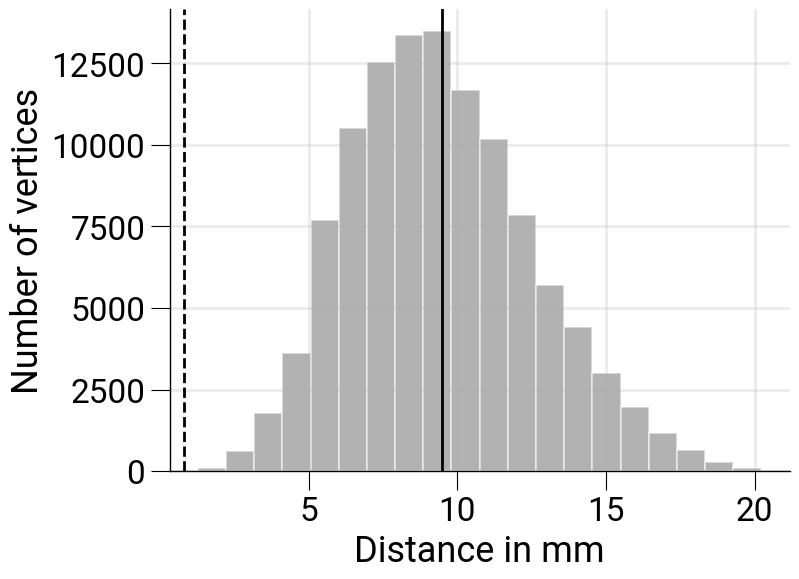

In [4]:
fig, ax = plt.subplots()
ax.hist(res, color="gray", alpha=0.6, bins=20, edgecolor="white", linewidth=1.2)
ax.set_xlabel(r"Distance in mm")
ax.axvline(np.mean(res), color="black")
ax.axvline(0.8, color="black", linestyle="dashed")
ax.set_ylabel("Number of vertices")
file_out = f"/data/pt_01880/distance_v1_v3_layer_{LAYER}_.svg"
fig.savefig(file_out, dpi=300, bbox_inches="tight", transparent=True, format="svg")